# Data Exploration

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import window_make
import Gradient

In [127]:
data = pd.read_csv('archive.csv') # co2 data

data.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958,1,1958.0411,NaN,NaN,NaN,NaN
1,1958,2,1958.1260,NaN,NaN,NaN,NaN
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [128]:
data = data.to_numpy()

co2 = data[:,3]

Text(0.5, 0, 'time series')

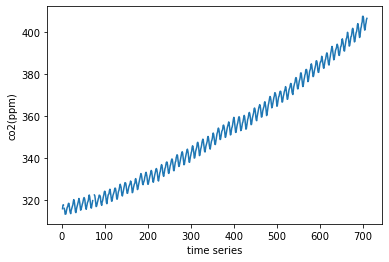

In [129]:
plt.plot(co2)
plt.ylabel('co2(ppm)')
plt.xlabel('time series')

In [130]:
X_i,Y_i = window_make.dowlist(co2,1) # Window sliding size 1 (a.k.a. predict CO2 ppm next month from previous month)

In [131]:
print("mean : ", np.mean(X_i))
print("standard deviation: ", np.std(X_i))

mean :  352.4508583690987
standard deviation:  26.113205449236176


In [132]:
print("x shape : ", X_i.shape)
print("y shape : ", Y_i.shape)

x shape :  (699, 1)
y shape :  (699, 1)


# polynomial regression

$ f(x) = a+bx+cx^{2}+dx^{3}+ex^{4}+fx^{5}$

$ w = (a,b,c,d,e,f)$

one variable polynomial regression : last month co2 concentration

# Stocastic Gradient Descent

In [133]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [134]:


X_train, X_test, Y_train, Y_test = train_test_split(X_i, Y_i, test_size=0.2, random_state=1)

scaler = MinMaxScaler()
scaler.fit(X_train)
x_scale = scaler.transform(X_train) # scaling train data
x_test = scaler.transform(X_test) # scaling test data using train data mean and std 

print("Scaled X_train",x_scale[:5])

print("=================================================")
poly = PolynomialFeatures(5)
x_train = poly.fit_transform(x_scale)
x_test = poly.fit_transform(x_test)
print("5th polynomial X_test",x_train[:5])

Scaled X_train [[0.84392015]
 [0.06469521]
 [0.0240205 ]
 [0.49236682]
 [0.44934344]]
5th polynomial X_test [[1.00000000e+00 8.43920145e-01 7.12201211e-01 6.01040950e-01
  5.07230566e-01 4.28062093e-01]
 [1.00000000e+00 6.46952066e-02 4.18546975e-03 2.70779830e-04
  1.75181571e-05 1.13334079e-06]
 [1.00000000e+00 2.40204975e-02 5.76984300e-04 1.38594499e-05
  3.32910882e-07 7.99668501e-09]
 [1.00000000e+00 4.92366820e-01 2.42425085e-01 1.19362068e-01
  5.87699219e-02 2.89363595e-02]
 [1.00000000e+00 4.49343440e-01 2.01909527e-01 9.07267213e-02
  4.07674570e-02 1.83185894e-02]]


In [135]:
print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(559, 6)
(140, 6)
(559, 1)
(140, 1)


In [136]:
loss, w_conv = Gradient.stochastic_gradient(x_train, Y_train, lr=0.0001, epoch=5000, batch_size=128)


In [137]:
print("Final Constants are",w_conv)

Final Constants are [315.10396543  79.18495115  21.85292999   2.5305232   -4.81679686
  -8.48693018]


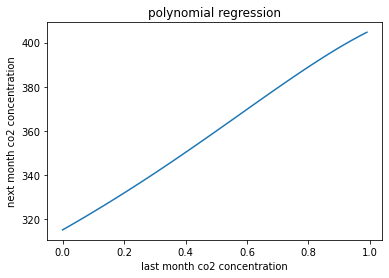

In [138]:
w_conv = w_conv.reshape((1,-1))
N = 100
x_index = 1/N * np.arange(N).reshape((-1,1))
poly = PolynomialFeatures(5)
x_index2 = poly.fit_transform(x_index)
x_index2 = np.transpose(x_index2)
y_index = np.matmul(w_conv, x_index2).reshape((-1,1))

plt.plot(x_index, y_index)
plt.title('polynomial regression')
plt.ylabel('next month co2 concentration')
plt.xlabel('last month co2 concentration')
plt.show()

In [139]:
predict_month = []
predict_list = []

for j,i in enumerate(co2):
    if not str(i) == 'nan':
        
        new_x = (i-min(X_train))/(max(X_train)-min(X_train))
        new_x = [new_x]
        predict_list.append(w_conv@poly.transform(new_x).T)
        
        predict_month.append(j)

    else:
        continue

Text(0.5, 0, 'time series')

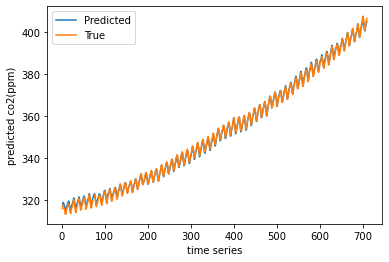

In [140]:
plt.plot(predict_month,[i[0][0] for i in  predict_list],label = 'Predicted')
plt.plot(co2,label = 'True')
plt.legend()
plt.ylabel('predicted co2(ppm)')
plt.xlabel('time series')

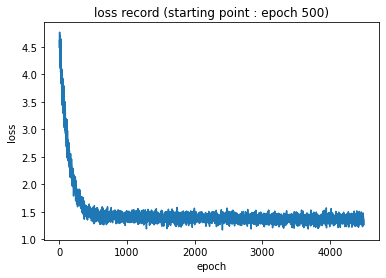

In [141]:
plt.plot(range(len(loss)-500), loss[500:])
plt.title('loss record (starting point : epoch 500)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [142]:
from sklearn.metrics import mean_squared_error

In [143]:
Y_pred = np.matmul(x_test,w_conv.reshape(6,-1)) 
mse = mean_squared_error(Y_test, Y_pred)
print("root mean squared error : ",np.sqrt(mse))

root mean squared error :  1.4022083240609031


Text(0.5, 1.0, 'comparison between true and regression')

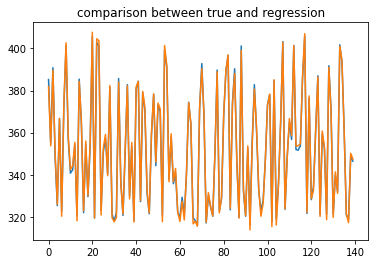

In [144]:
plt.plot(Y_pred, label='prediction')
plt.plot(Y_test, label='true value')
plt.title('comparison between true and regression')

# Parameter Change

In [145]:
import time
lr_set = [0.00001, 0.0001, 0.001]
batch_set = [32, 64, 128, 256]
epoch_size = 5000
rmse = np.zeros((len(lr_set), len(batch_set)))
time_record = np.zeros((len(lr_set),len(batch_set)))

for i in range(len(lr_set)):
    
    hyper = lr_set[i]
    
    for j in range(len(batch_set)):
        
        batch = batch_set[j]
        
        start = time.time()
        loss, w_conv = Gradient.stochastic_gradient(x_train, Y_train, lr=hyper, epoch=epoch_size, batch_size=batch)
        time_cal = time.time() - start
        
        time_record[i,j] = time_cal
        Y_pred = np.matmul(x_test,w_conv.reshape((6,-1))) 
        rmse[i,j] = mean_squared_error(Y_test, Y_pred)
        print("learning_rate = ", hyper)
        print("batch_size = ", batch)
        
        

learning_rate =  1e-05
batch_size =  32
learning_rate =  1e-05
batch_size =  64
learning_rate =  1e-05
batch_size =  128
learning_rate =  1e-05
batch_size =  256
learning_rate =  0.0001
batch_size =  32
learning_rate =  0.0001
batch_size =  64
learning_rate =  0.0001
batch_size =  128
learning_rate =  0.0001
batch_size =  256
learning_rate =  0.001
batch_size =  32
learning_rate =  0.001
batch_size =  64
learning_rate =  0.001
batch_size =  128
learning_rate =  0.001
batch_size =  256


In [106]:
print(time_record)
print(rmse)

[[0.91716099 1.73742008 3.33854628 6.60254407]
 [0.91411495 1.72297502 3.42099285 6.69522476]
 [0.91230321 1.757622   3.30366397 6.54773784]]
[[1132.75071697  298.78816001   23.28381233    2.4249081 ]
 [   2.3109023     2.14953997    1.93720234    1.83592247]
 [   1.86205315    1.7584        1.6210186     1.5323056 ]]


In [147]:
Best_Parameter = np.where(rmse==np.min(rmse))
print("Learning Rate",lr_set[Best_Parameter[0][0]])
print("batch size",batch_set[Best_Parameter[1][0]])

Learning Rate 0.001
batch size 256


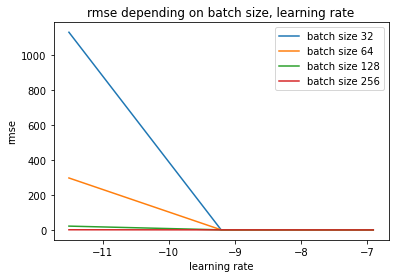

In [123]:
plt.plot(np.log(lr_set), rmse[:,0], label='batch size 32')
plt.plot(np.log(lr_set), rmse[:,1], label='batch size 64')
plt.plot(np.log(lr_set), rmse[:,2], label='batch size 128')
plt.plot(np.log(lr_set), rmse[:,3], label='batch size 256')
plt.title('rmse depending on batch size, learning rate')
plt.xlabel('learning rate')
plt.ylabel('rmse')
plt.legend()
plt.show()

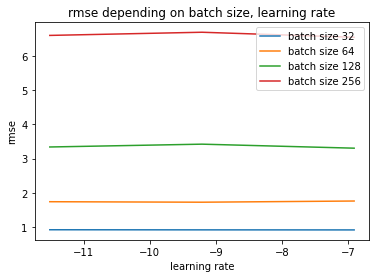

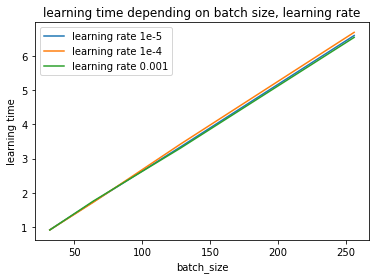

In [107]:

plt.plot(np.log(lr_set), time_record[:,0], label='batch size 32')
plt.plot(np.log(lr_set), time_record[:,1], label='batch size 64')
plt.plot(np.log(lr_set), time_record[:,2], label='batch size 128')
plt.plot(np.log(lr_set), time_record[:,3], label='batch size 256')
plt.title('rmse depending on batch size, learning rate')
plt.xlabel('learning rate')
plt.ylabel('rmse')
plt.legend()
plt.show()


plt.plot(batch_set, time_record[0,:], label='learning rate 1e-5')
plt.plot(batch_set, time_record[1,:], label='learning rate 1e-4')
plt.plot(batch_set, time_record[2,:], label='learning rate 0.001')
plt.title('learning time depending on batch size, learning rate')
plt.xlabel('batch_size')
plt.ylabel('learning time')
plt.legend()
plt.show()

# 2 feature

$[x_{1},x_{2}]$=[6 month ago data, this month data] <br>
5th order : $(x_{1})^{5}, (x_{1})^{4}(x_{2})^{1}, (x_{1})^{3}(x_{2})^{2}, (x_{1})^{2}(x_{2})^{3}, (x_{1})^{1}(x_{2})^{4}, (x_{2})^{5}$

In [108]:
X_6,Y_i = window_make.dowlist(co2,6)
X_i = np.hstack([X_6[:,0].reshape((-1,1)), X_6[:,5].reshape((-1,1))])
print(X_i.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X_i, Y_i, test_size=0.2, random_state=1)

(685, 2)


In [109]:
print(X_i[:5])

[[313.33 317.72]
 [314.67 318.29]
 [315.58 318.15]
 [316.48 316.54]
 [316.65 314.8 ]]


In [110]:
minmax = MinMaxScaler()
minmax.fit(X_train)
x_scale = minmax.transform(X_train) # scaling train data
x_test = minmax.transform(X_test) # scaling test data using train data mean and std 

print(x_scale[0])

poly = PolynomialFeatures(5)
x_train = poly.fit_transform(x_scale)
x_test = poly.fit_transform(x_test)

print(x_train[0])

[0.92175674 0.93664438]
[1.         0.92175674 0.93664438 0.84963549 0.86335827 0.8773027
 0.78315724 0.79580631 0.80865968 0.82172064 0.72188047 0.73353983
 0.74538751 0.75742654 0.76966002 0.66539819 0.67614529 0.68706596
 0.69816302 0.70943931 0.72089773]


In [111]:
print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(548, 21)
(137, 21)
(548, 1)
(137, 1)


In [112]:
loss, w_conv = Gradient.stochastic_gradient(x_train, Y_train, lr=0.0001, epoch=5000, batch_size=32)

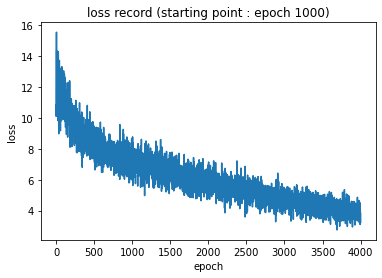

In [113]:
plt.plot(range(len(loss[1000:])), loss[1000:])
plt.title('loss record (starting point : epoch 1000)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [114]:
Y_pred = np.matmul(x_test,w_conv.reshape(-1,1)) 
mse = mean_squared_error(Y_test, Y_pred)
print("root mean squared error : ",np.sqrt(mse))

root mean squared error :  4.058248592151758


Text(0.5, 1.0, 'comparison between true and regression')

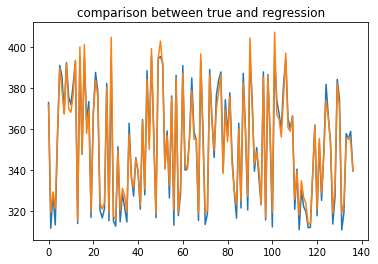

In [115]:
plt.plot(Y_pred, label='prediction')
plt.plot(Y_test, label='true value')
plt.title('comparison between true and regression')

In [116]:
w_conv = w_conv.reshape((1,-1))
N = 100
x_index = 1/N * np.arange(N).reshape((-1,1))
x_multi = np.hstack([x_index, x_index])
poly = PolynomialFeatures(5)
x_index2 = poly.fit_transform(x_multi)

In [117]:
print(x_index.shape)

(100, 1)


In [118]:
w_conv = w_conv.reshape((1,-1))
N = 100
x_index = 1/N * np.arange(N).reshape((-1,1))
x_multi = np.hstack([x_index, x_index])
poly = PolynomialFeatures(5)
x_index2 = poly.fit_transform(x_multi)
x_index2 = np.transpose(x_index2)
y_index = np.matmul(w_conv, x_index2).reshape((-1,1))



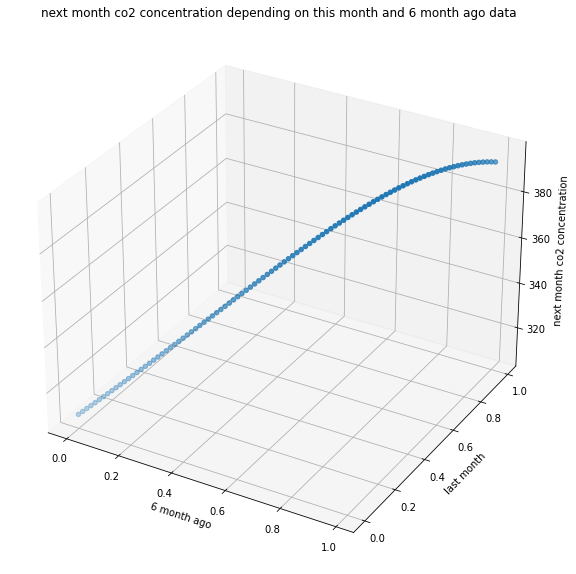

In [119]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_index, x_index, y_index)
ax.set_title('next month co2 concentration depending on this month and 6 month ago data')
ax.set_xlabel('6 month ago')
ax.set_ylabel('last month')
ax.set_zlabel('next month co2 concentration')
plt.show()